# MNIST Prediction with Full TF Model
Lauren, Peach || INFO 371 Ad Hoc, Otty the Otto Toomet

## Notes:
- Throw away the <MAYBE THROW THIS AWAY> section @ the end if irrelevant

In [36]:
# General
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

# Image processing
from PIL import Image
import gzip
import os
import re

# Image

## Maybe throw this away

In [8]:
f = gzip.open('../data/fullDataset/train-images-idx3-ubyte.gz','r')

In [9]:
image_size = 28
num_images = 60000

f.read(16)

# read rest of file as buffer
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)

In [10]:
# Take a look at whether the data looks right
print(data.shape) # 60000 x 28 x 28 x 1
print(data[0].shape) # 28 x 28 x 1
print(data[0, :, :, 0])

(60000, 28, 28, 1)
(28, 28, 1)
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253. 225. 

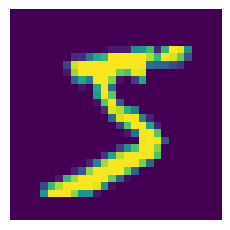

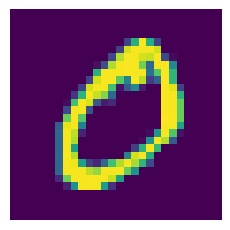

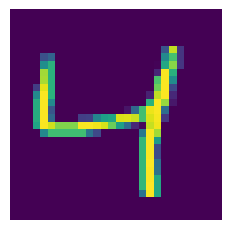

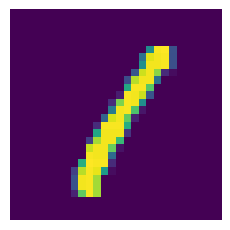

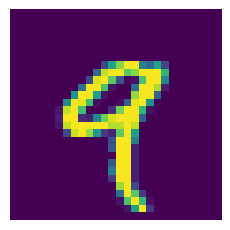

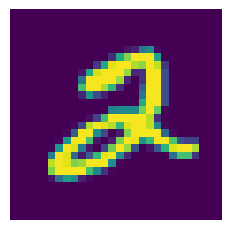

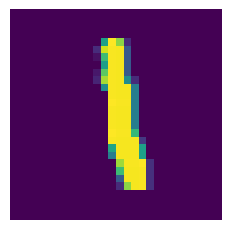

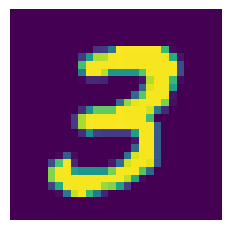

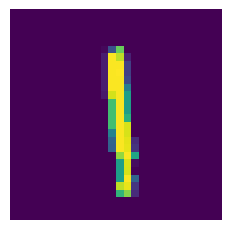

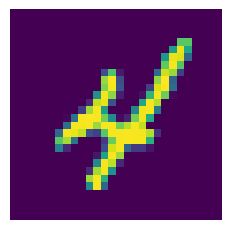

In [12]:
my_dpi=96
length = 10 # len(data)
for i in range(0, length):
    fig_name = "train_" + str(i) + ".png"
    image = np.asarray(data[i]).squeeze()
    plt.figure(figsize=(280/my_dpi, 280/my_dpi), dpi=my_dpi)
    plt.axis('off')
    plt.imshow(image)
    # uncomment this part if you want to save the images
#     plt.imsave("./train_img/" + fig_name, arr=image, cmap='gray', format='png')

In [16]:
FUNKY_SIZE = 30000

f = gzip.open('../data/fullDataset/train-labels-idx1-ubyte.gz','r') # keep this in! even if we loaded it earlier. or you'll run into some error
f.read(8)

funky_y = np.empty(shape = FUNKY_SIZE, dtype = int)

for i in range(0, FUNKY_SIZE):  
    buf = f.read(1)
    funky_y[i] = np.frombuffer(buf, dtype=np.uint8)

b
funky_y = funky_y.reshape(-1, 1)
funky_y[:1000]

array([[5],
       [0],
       [4],
       [1],
       [9],
       [2],
       [1],
       [3],
       [1],
       [4],
       [3],
       [5],
       [3],
       [6],
       [1],
       [7],
       [2],
       [8],
       [6],
       [9],
       [4],
       [0],
       [9],
       [1],
       [1],
       [2],
       [4],
       [3],
       [2],
       [7],
       [3],
       [8],
       [6],
       [9],
       [0],
       [5],
       [6],
       [0],
       [7],
       [6],
       [1],
       [8],
       [7],
       [9],
       [3],
       [9],
       [8],
       [5],
       [9],
       [3],
       [3],
       [0],
       [7],
       [4],
       [9],
       [8],
       [0],
       [9],
       [4],
       [1],
       [4],
       [4],
       [6],
       [0],
       [4],
       [5],
       [6],
       [1],
       [0],
       [0],
       [1],
       [7],
       [1],
       [6],
       [3],
       [0],
       [2],
       [1],
       [1],
       [7],
       [9],
       [0],
       [2],
    

## Reading training images/labels from the original dataset

In [23]:
def training_images():
    with gzip.open('../data/fullDataset/train-images-idx3-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images

In [24]:
def training_labels():
    with gzip.open('../data/fullDataset/train-labels-idx1-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [27]:
images = training_images()
labels = training_labels()

In [30]:
print(images.shape) # see if data read in correctly
print(labels) # look at labels
print(len(labels)) # check if no of labels match up

(60000, 28, 28)
[5 0 4 ... 5 6 8]
60000


In [ ]:
my_dpi = 96
for i in range(0,30001): #
    fig_name = "train_" + str(i) + ".png"
    image = np.asarray(images[i]).squeeze()
    plt.figure(figsize=(280/my_dpi, 280/my_dpi), dpi=my_dpi)
    plt.axis('off')
#     plt.imshow(image) # don't be dump like lauren
    plt.imsave("../data/train_img/" + fig_name, arr=image, cmap='gray', format='png')

9


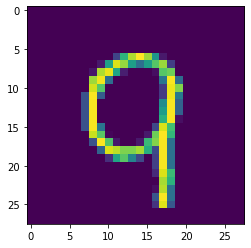

In [31]:
# check if labels and images match up
i = 26512

plt.imshow(images[i])
print(labels[i])

In [34]:
# sort the images by smallest to largest
# without this you will get 0, 1, 10 etc; bc we don't have 000s (shitty file naming system oops)
image_names = os.listdir("./../data/train_img")[:FUNKY_SIZE]
image_names.sort(key=lambda f: int(re.sub('\D', '', f)))
image_names[0:30000]

['train_0.png',
 'train_1.png',
 'train_2.png',
 'train_3.png',
 'train_4.png',
 'train_5.png',
 'train_6.png',
 'train_7.png',
 'train_8.png',
 'train_9.png',
 'train_10.png',
 'train_11.png',
 'train_12.png',
 'train_13.png',
 'train_14.png',
 'train_15.png',
 'train_16.png',
 'train_17.png',
 'train_18.png',
 'train_19.png',
 'train_20.png',
 'train_21.png',
 'train_22.png',
 'train_23.png',
 'train_24.png',
 'train_25.png',
 'train_26.png',
 'train_27.png',
 'train_28.png',
 'train_29.png',
 'train_30.png',
 'train_31.png',
 'train_32.png',
 'train_33.png',
 'train_34.png',
 'train_35.png',
 'train_36.png',
 'train_37.png',
 'train_38.png',
 'train_39.png',
 'train_40.png',
 'train_41.png',
 'train_42.png',
 'train_43.png',
 'train_44.png',
 'train_45.png',
 'train_46.png',
 'train_47.png',
 'train_48.png',
 'train_49.png',
 'train_50.png',
 'train_51.png',
 'train_52.png',
 'train_53.png',
 'train_54.png',
 'train_55.png',
 'train_56.png',
 'train_57.png',
 'train_58.png',
 'train

In [37]:
X_train_big = []
for img in image_names:  
    # convert image to 1 color channel 
    colorImage = Image.open("./../data/train_img/" + img).convert('1')
    
    # rotating the thing
    degrees = random.randint(-20,20)
    rptated = colorImage.rotate(degrees)
    
    # getting the data
    image_sequence = rptated.getdata()
    image_array = np.array(image_sequence).reshape(28,28)
    
    # switching to float 
    float_array = image_array.astype(float)
    X_train_big.append(float_array)

# changing to numpy array
funky_x = np.array(X_train_big)
funky_x.shape

(30000, 28, 28)

In [38]:
np.array(funky_y)

array([[5],
       [0],
       [4],
       ...,
       [6],
       [7],
       [1]])

[4]


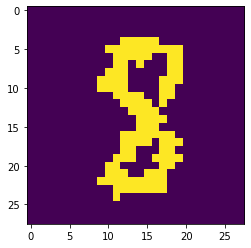

In [45]:
# check if labels/images are read properly
# F
i = 23999
plt.imshow(funky_x[i])
print(funky_y[i])

[7]


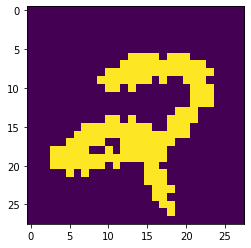

In [46]:
# check if labels/images are read properly
i = 23000
plt.imshow(funky_x[i])
print(funky_y[i])

[5]


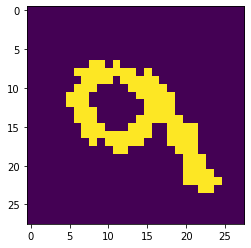

In [47]:
# check if labels/images are read properly
i = 20000
plt.imshow(funky_x[i])
print(funky_y[i])

[2]


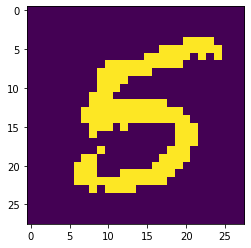

In [53]:
# check if labels/images are read properly
i = 19999
plt.imshow(funky_x[i])
print(funky_y[i])

In [70]:
# since the images/labels are weird at 20,000/after 20,000
# let's only use the first 20k images
x_data = funky_x[0:19999]
y_data = funky_y[0:19999]

In [73]:
# splits the data
X_train_funky, X_test_funky, y_train_funky, y_test_funky = train_test_split(x_data, y_data, test_size = 0.2, random_state=1)

# split looks right
print(X_train_funky.shape)
print(X_test_funky.shape)
print(y_train_funky.shape)
print(y_test_funky.shape)

(15999, 28, 28)
(4000, 28, 28)
(15999, 1)
(4000, 1)


# Model

In [116]:
# set some globals, which are used across the remaining functions
Image_width = 28
Image_height = 28
Image_Channels = 1
IMAGE_SHAPE = (Image_width, Image_height, Image_Channels)
NUM_CLASSES = 10

# training parameters
NUM_EPOCHS = 30
BATCH_SIZE = 128

In [80]:
# Testing Ott's Cats and dog model
model = Sequential()

# should feed in input shape [28,28]
# only looking at image height and width

model.add(Flatten(input_shape=[28,28]))

model.add(Dense(512, activation='relu'))

model.add(Dense(256, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(50, activation='relu'))

model.add(Dense(10, activation='softmax'))

In [81]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
Total params: 573,104
Trainable params: 573,104
Non-trainable params: 0
__________________________________________________

In [86]:
# convert to 0 and 1's 
X_train_funky = (X_train_funky.astype('float32') / 255.0)
X_test_funky = (X_test_funky.astype('float32') / 255.0)

# reshape it
# make sure to reshape to right data values!
X_train_funky = X_train_funky.reshape(15999, 28, 28)
X_test_funky = X_test_funky.reshape(4000, 28, 28)

# y train
y_train_funky = y_train_funky.astype('float32')
y_train_funky.dtype

dtype('float32')

In [87]:
np.any(np.isnan(X_train_funky))

False

In [88]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=['accuracy'])

model.fit(X_train_funky, y_train_funky, epochs=50)

Epoch 1/50
500/500 [==============================] - 2s 3ms/step - loss: 2.3022 - accuracy: 0.1076
Epoch 2/50
500/500 [==============================] - 1s 3ms/step - loss: 2.3011 - accuracy: 0.1120
Epoch 3/50
500/500 [==============================] - 1s 3ms/step - loss: 2.3011 - accuracy: 0.1095
Epoch 4/50
500/500 [==============================] - 2s 3ms/step - loss: 2.2998 - accuracy: 0.1137
Epoch 5/50
500/500 [==============================] - 2s 4ms/step - loss: 2.3008 - accuracy: 0.1122
Epoch 6/50
500/500 [==============================] - 2s 3ms/step - loss: 2.3007 - accuracy: 0.1128
Epoch 7/50
500/500 [==============================] - 2s 4ms/step - loss: 2.3008 - accuracy: 0.1139
Epoch 8/50
500/500 [==============================] - 2s 5ms/step - loss: 2.3014 - accuracy: 0.1075
Epoch 9/50
500/500 [==============================] - 2s 4ms/step - loss: 2.3011 - accuracy: 0.1080
Epoch 10/50
500/500 [==============================] - 2s 4ms/step - loss: 2.3014 - accuracy: 0.1097

## Model Prediction

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


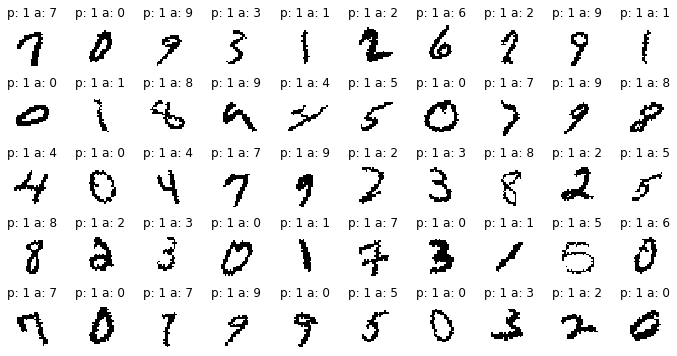

In [89]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
predicted_val = []

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_test_funky[index], cmap="binary", interpolation="nearest")
        pred = model.predict_classes(X_test_funky[index:index+1])[0]
        value = y_test_funky[index][0]
        #print(value)
        predicted_val.append(pred)
        plt.title("p: {} a: {}".format(pred, value))
        plt.axis('off')
        
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Model Accuracy

In [90]:
#  predicting the number and selecting the digit that is most probable 
prediction = model.predict(X_test_funky)
predictedValue = prediction.argmax(axis=1)

# Comparing predicted digit to the actual digit value to determine the accuracy of the model
accuracy = np.mean(y_test_funky.ravel() == predictedValue.ravel())
accuracy

0.1185

# Convolution Model

In [96]:
X_train = X_train_funky.copy()
y_train = y_train_funky.copy()
X_test = X_test_funky.copy()
y_test = y_test_funky.copy()

K.clear_session()

from tensorflow.keras.utils import to_categorical

print('Before preprocessing:')
print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
print(' - X_test.shape = {}'.format(X_test.shape))

# one-hot encode labels to 10 output classes corresponding to digits 0-9
y_train = to_categorical(y_train, 10)

# reshape the image arrays (make 2D arrays instead of 3D arrays)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

print('After preprocessing: ')
print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
print(' - X_test.shape = {}'.format(X_test.shape))

Before preprocessing:
 - X_train.shape = (15999, 28, 28), y_train.shape = (15999, 1)
 - X_test.shape = (4000, 28, 28)
After preprocessing: 
 - X_train.shape = (15999, 28, 28, 1), y_train.shape = (15999, 10)
 - X_test.shape = (4000, 28, 28, 1)


In [117]:
# IMAGE_SHAPE = (15999, 28, 28, 1)
def build_model():
    K.clear_session()
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(6), padding='same', activation='relu',
                    input_shape=IMAGE_SHAPE)) # **** KEEP THIS TOO 
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64, kernel_size=(3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(128, kernel_size=(2), padding='same', activation='relu',
                input_shape=IMAGE_SHAPE))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    ## Add desnse layers 
    model.add(Dense(32, activation = 
                    'relu'))
    model.add(Dropout(0.45))
    # output is softmax for 10 classes
    model.add(Dense(10,activation = 'softmax')) # ****** NEED THIs STRIP TO THIS AND A INPUT LAYER 
    adam = optimizers.Adam(lr = 0.001)
    
    model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['acc'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [108]:
NUM_EPOCHS = 2

In [120]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=['accuracy'])


# need to reshape otherwise it throws some error about dimensions
# https://stackoverflow.com/questions/63279168/valueerror-input-0-of-layer-sequential-is-incompatible-with-the-layer-expect
X_train_funky = X_train_funky.reshape(-1, 28, 28, 1) 

model.fit(X_train_funky, y_train_funky, epochs=50)

Epoch 1/50
500/500 [==============================] - 14s 28ms/step - loss: 2.3022 - accuracy: 0.1022
Epoch 2/50
500/500 [==============================] - 15s 31ms/step - loss: 2.3012 - accuracy: 0.1122
Epoch 3/50
500/500 [==============================] - 16s 32ms/step - loss: 2.3005 - accuracy: 0.1150
Epoch 4/50
500/500 [==============================] - 14s 29ms/step - loss: 2.3010 - accuracy: 0.1107
Epoch 5/50
500/500 [==============================] - 15s 30ms/step - loss: 2.3005 - accuracy: 0.1141
Epoch 6/50
500/500 [==============================] - 14s 29ms/step - loss: 2.3009 - accuracy: 0.1111
Epoch 7/50
500/500 [==============================] - 17s 34ms/step - loss: 2.3008 - accuracy: 0.1132
Epoch 8/50
500/500 [==============================] - 14s 28ms/step - loss: 2.2997 - accuracy: 0.1135
Epoch 9/50
500/500 [==============================] - 14s 28ms/step - loss: 2.3009 - accuracy: 0.1123
Epoch 10/50
500/500 [==============================] - 21s 43ms/step - loss: 2.300

# Miscellaneous

In [ ]:
# convert image to black/white
colorImage = Image.open("./../data/train_img/train_1.png").convert('1')
image_sequence = colorImage.getdata()
image_array = np.array(image_sequence).reshape(28,28)
image_array.shape

# check if rotating works
rotated = colorImage.rotate(22)
rotated.show()